# analysis_prelim_p17c.ipynb

## Purpose
Preliminary analysis of CESM simulation output from project [p17c-marc-comparison](https://github.com/grandey/p17c-marc-comparison).

## Requirements
- Post-processed CESM output from [cdo_analysis_prelim_p17c.sh](https://github.com/grandey/p17c-marc-comparison/blob/master/analysis_prelim/cdo_analysis_prelim_p17c.sh).
- Python modules mentioned in next cell, inlcuding [climapy](https://github.com/grandey/climapy).

## Author
Benjamin S. Grandey, 2017

In [1]:
import climapy
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import os
import scipy
import xarray as xr

# Print versions of packages
for module in [climapy, np, scipy, xr]:
    try:
        print('{}.__version__ = {}'.format(module.__name__, module.__version__))
    except AttributeError:
        pass

%matplotlib inline

climapy.__version__ = 0.0.1+0597060
numpy.__version__ = 1.13.1
scipy.__version__ = 0.19.1
xarray.__version__ = 0.9.6


## Post-processed data file location
Location of files written by [cdo_analysis_prelim_p17c.sh](https://github.com/grandey/p17c-marc-comparison/blob/master/analysis_prelim/cdo_analysis_prelim_p17c.sh), including annual means for years 3-32.

In [2]:
in_dir = os.path.expandvars('$HOME/data/projects/p17c_marc_comparison/cdo_analysis_prelim/')

## Function to produce zonal mean line plot
- Put latitude on y-axis for consistency with maps

In [29]:
def zonal_mean_line_plot(year='2000', model_var_dict={'mam3': 'BURDENPOM'},
                         sf=None, xlabel=None, xlim=None,
                         ylabel=True, 
                         title=None,
                         ax=None):
    # Create Axes if no Axes passed as an argument
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    # If no scale-factor specified, set as 1
    if sf is None:
        sf = 1
    # Loop over model-variable combinations
    for model, var_name in model_var_dict.items():
        # Color based on model
        if model == 'marc':
            c = 'r'
            alpha = 1
            linestyle = '-'
        elif model == 'mam3':
            c = 'g'
            alpha = 0.75
            linestyle = '--'
        elif model == 'mam7':
            c = 'b'
            alpha = 0.5
            linestyle = ':'
        # Case 1: single year (1850 or 2000)
        if year in ['1850', '2000']:
            # Load annual mean data
            in_filename = '{}/s1.ym.p17c_{}_{}.cam.h0.{}.nc'.format(in_dir, model, year, var_name)
            data = xr.open_dataset(in_filename, decode_times=False)
            data = climapy.cesm_time_from_bnds(data)  # populate time dimension using climapy
            # Calculate zonal mean
            zm = data.mean(dim='lon')
            # Plot line - showing mean across time
            tm = zm.mean(dim='time')[var_name].data.flatten() * sf
            ax.plot(tm, zm['lat'].data,
                    c=c, alpha=alpha, linestyle=linestyle,
                    label=model.upper())
            # Plot shading - based on standard error
            error = zm.std(dim='time', ddof=1)[var_name].data.flatten() / np.sqrt(zm['time'].size) * sf
            ax.fill_betweenx(zm['lat'].data, tm-error, tm+error,
                             facecolor=c, alpha=0.1)
            # Close dataset
            data.close()
        # Case 2: difference (2000-1850)
        if year == '2000-1850':
            # Load annual mean data
            in_filename1 = '{}/s2.zm.ym.p17c_{}_{}.cam.h0.{}.nc'.format(in_dir, model, '2000', var_name)
            data1 = xr.open_dataset(in_filename1, decode_times=False)
            data1 = climapy.cesm_time_from_bnds(data1)
            in_filename2 = '{}/s2.zm.ym.p17c_{}_{}.cam.h0.{}.nc'.format(in_dir, model, '1850', var_name)
            data2 = xr.open_dataset(in_filename2, decode_times=False)
            data2 = climapy.cesm_time_from_bnds(data2)
            # Calculate zonal means
            zm1 = data1.mean(dim='lon')
            zm2 = data2.mean(dim='lon')
            # Plot line - showing difference of means across time
            tm1 = zm1.mean(dim='time')[var_name].data.flatten() * sf
            tm2 = zm2.mean(dim='time')[var_name].data.flatten() * sf
            tm = tm1 - tm2
            ax.plot(tm, zm1['lat'].data,
                    c=c, alpha=alpha, linestyle=linestyle,
                    label=model.upper())
            # Plot shading - based on combined standard error
            error1 = zm1.std(dim='time', ddof=1)[var_name].data.flatten() / np.sqrt(zm1['time'].size) * sf
            error2 = zm2.std(dim='time', ddof=1)[var_name].data.flatten() / np.sqrt(zm2['time'].size) * sf
            error = np.sqrt(error1**2 + error2**2)
            ax.fill_betweenx(zm1['lat'].data, tm-error, tm+error,
                             facecolor=c, alpha=0.1)
            # Close datasets
            data1.close()
            data2.close()
    # Lines showing zero
    ax.axhline(0, c='k', alpha=0.2, linewidth=1, linestyle='--')
    ax.axvline(0, c='k', alpha=0.2, linewidth=1, linestyle='--')
    # y-axis
    ax.set_ylim([-90, 90])
    ax.set_yticks(np.arange(-90, 91, 30))
    if ylabel:
        ax.set_ylabel(r'Latitude, $^\circ$N', fontsize='large')
    # x-axis
    if xlabel:
        ax.set_xlabel(xlabel, fontsize='large')
    if xlim:
        ax.set_xlim(xlim)
    # Title and legend
    if title:
        ax.set_title(title, fontsize='large')
    ax.legend()
    return ax

# Examples
if False:
    # Example 1
    fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True, sharex=True)
    for year, ylabel, title, ax in zip(['1850', '2000'], [True, False], ['(a) Year-1850', '(b) Year-2000'], axs):
        zonal_mean_line_plot(year=year, model_var_dict={'marc': 'BC_LDG', 'mam3': 'BURDENBC'},
                             sf=1e6, xlabel=r'BC column burden, mg m$^{-2}$', xlim=[0, 0.35],
                             ylabel=ylabel, title=title, ax=ax)
    # Example 2
    ax = zonal_mean_line_plot(year='2000-1850', model_var_dict={'marc': 'cFNTOA', 'mam3': 'cFNTOA'},
                              xlabel=r'Net RFP, W m$^{-2}$')

## Zonal means of column burdens
- 2 columns: year-1850, year-2000
- 5 rows: pure sulphate, OC, BC, MOS, MBS
- 1-3 lines per panel (showing different models)

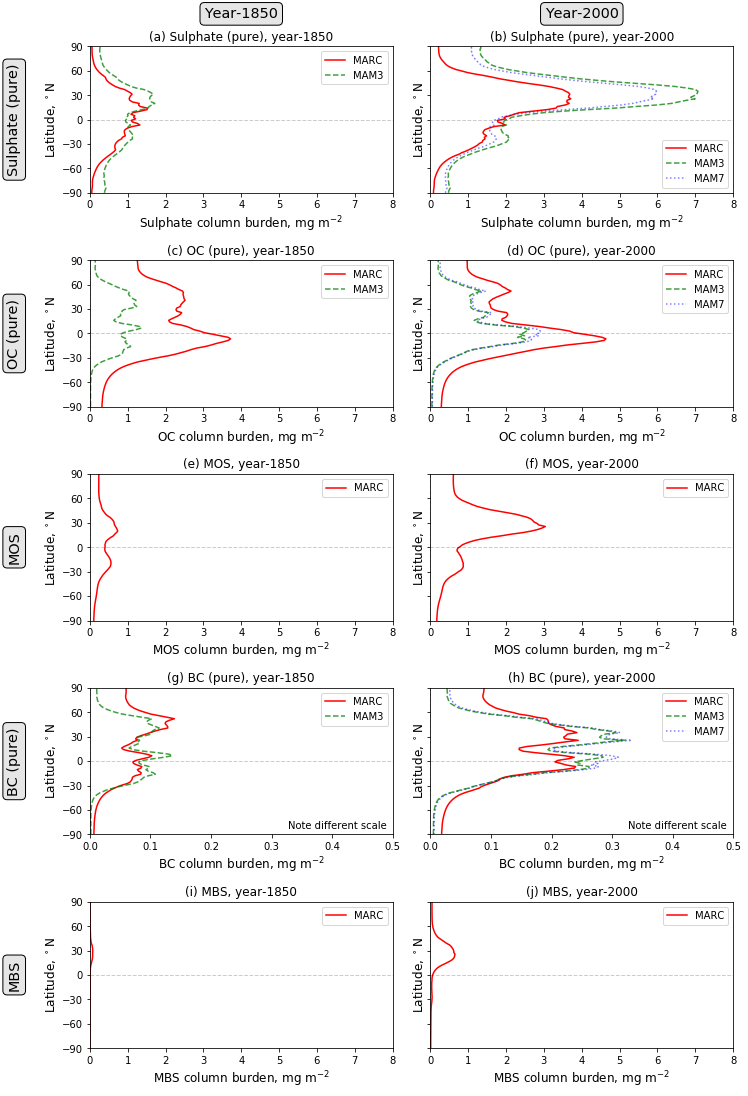

In [30]:
fig, axs = plt.subplots(5, 2, figsize=(10, 15), sharey=True, sharex=False)
# Loop over species (rows)
for species, r in zip(('Sulphate (pure)', 'OC (pure)', 'MOS', 'BC (pure)', 'MBS'), range(5)):
    # Information for different species
    sf=1e6
    xlim=[0, 8]  # all except BC
    if species == 'Sulphate (pure)':
        model_var_dict={'marc': 'pSUL_LDG', 'mam3': 'BURDENSO4'}
        xlabel='Sulphate column burden, mg m$^{-2}$'
    elif species == 'OC (pure)':
        model_var_dict={'marc': 'OC_LDG', 'mam3': 'BURDENPOM'}
        xlabel='OC column burden, mg m$^{-2}$'
    elif species == 'BC (pure)':
        model_var_dict={'marc': 'BC_LDG', 'mam3': 'BURDENBC'}
        xlabel='BC column burden, mg m$^{-2}$'
        xlim=[0, 0.5]
    elif species == 'MOS':
        model_var_dict={'marc': 'MOS_LDG'}
        xlabel='MOS column burden, mg m$^{-2}$'
    elif species == 'MBS':
        model_var_dict={'marc': 'MBS_LDG'}
        xlabel='MBS column burden, mg m$^{-2}$'
    # Loop over years (columns)    
    for year, c in zip(('1850', '2000'), range(2)):
        # If year-2000, include MAM7
        if year == '2000' and species not in ['MOS', 'MBS']:
            model_var_dict['mam7'] = model_var_dict['mam3']
        # Title
        title = '({}) {}, year-{}'.format(chr(97+c+r*2), species, year)
        # If year-1850, include ylabel
        if year == '1850':
            ylabel = True
        else:
            yabel = False
        # Plot panel
        zonal_mean_line_plot(year=year, model_var_dict=model_var_dict,
                             sf=sf, xlabel=xlabel, xlim=xlim,
                             ylabel=ylabel, title=title, ax=axs[r, c])
# Row and column titles
for species, r in zip(('Sulphate (pure)', 'OC (pure)', 'MOS', 'BC (pure)', 'MBS'), range(5)):
    xlim = axs[r, 0].get_xlim()
    xpos = -0.25 * xlim[1]
    axs[r, 0].text(xpos, 0, species,
                   fontsize='x-large', verticalalignment='center', horizontalalignment='center',
                   rotation=90,
                   bbox={'boxstyle': 'round', 'fc': '0.9', 'ec': 'k'})
for year, c in zip(('1850', '2000'), range(2)):
    axs[0, c].text(4, 130, 'Year-{}'.format(year),
                   fontsize='x-large', verticalalignment='center', horizontalalignment='center',
                   bbox={'boxstyle': 'round, pad=0.3', 'fc': '0.9', 'ec': 'k'})
# Other annotation
for c in range(2):
    axs[3, c].text(0.49, -85, 'Note different scale',
                   verticalalignment='bottom', horizontalalignment='right')
# Prevent overlapping labels
fig.tight_layout()
# Save
fig.savefig('temp.pdf', bbox_inches='tight')

## Zonal means of cloud water path
- 2 columns: year-1850, year-2000
- 2 rows: liquid water path, ice water path
- 2-3 lines per panel (showing different models)

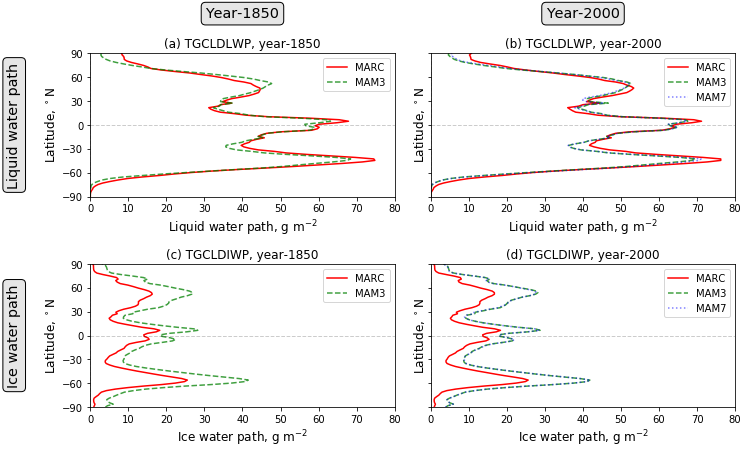

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6), sharey=True, sharex=False)
# Loop over variable (rows)
for var_name, xlabel, r in zip(['TGCLDLWP', 'TGCLDIWP'],
                               [r'Liquid water path, g m$^{-2}$', 'Ice water path, g m$^{-2}$'],
                               range(2)):
    sf = 1e3
    xlim = [0, 80]
    model_var_dict={'marc': var_name, 'mam3': var_name}    
    # Loop over years (columns)    
    for year, c in zip(('1850', '2000'), range(2)):
        # If year-1850, include ylabel
        if year == '1850':
            ylabel = True
        # If year-2000, include MAM7
        else:
            model_var_dict['mam7'] = var_name
            yabel = False
        # Title
        title = '({}) {}, year-{}'.format(chr(97+c+r*2), var_name, year)
        # Plot panel
        zonal_mean_line_plot(year=year, model_var_dict=model_var_dict,
                             sf=sf, xlabel=xlabel, xlim=xlim,
                             ylabel=ylabel, title=title, ax=axs[r, c])
# Row and column titles
for var_long, r in zip(['Liquid water path', 'Ice water path'], range(2)):
    xlim = axs[r, 0].get_xlim()
    xpos = -0.25 * xlim[1]
    axs[r, 0].text(xpos, 0, var_long,
                   fontsize='x-large', verticalalignment='center', horizontalalignment='center',
                   rotation=90,
                   bbox={'boxstyle': 'round', 'fc': '0.9', 'ec': 'k'})
for year, c in zip(('1850', '2000'), range(2)):
    xlim = axs[r, 0].get_xlim()
    xpos = np.mean(xlim)
    axs[0, c].text(xpos, 140, 'Year-{}'.format(year),
                   fontsize='x-large', verticalalignment='center', horizontalalignment='center',
                   bbox={'boxstyle': 'round, pad=0.3', 'fc': '0.9', 'ec': 'k'})
# Prevent overlapping labels
fig.tight_layout()
# Save
fig.savefig('temp.pdf', bbox_inches='tight')